The idea is to **align the timestamp by peak air temperature**, based on an assumption that the highest air temperature should appear at around 14:00.

After aligning the timestamp of weather data, LB jumped from 1.12 to 1.11.

**First, why do we do this timestamp alignment?**

In [1]:
import gc
import os
from pathlib import Path
import random
import sys
from os.path import join as pjoin

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [2]:
RAW_DATA_DIR = '/kaggle/input/ashrae-energy-prediction/'

weather_dtypes = {
    'site_id': np.uint8,
    'air_temperature': np.float32,
    'cloud_coverage': np.float32,
    'dew_temperature': np.float32,
    'precip_depth_1_hr': np.float32,
    'sea_level_pressure': np.float32,
    'wind_direction': np.float32,
    'wind_speed': np.float32,
}

weather_train = pd.read_csv(pjoin(RAW_DATA_DIR, 'weather_train.csv'),dtype=weather_dtypes,
    parse_dates=['timestamp'])
weather_test = pd.read_csv(pjoin(RAW_DATA_DIR, 'weather_test.csv'),dtype=weather_dtypes,
    parse_dates=['timestamp'])

weather = pd.concat([weather_train,weather_test],ignore_index=True)
del weather_train, weather_test
weather_key = ['site_id', 'timestamp']
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()
del weather

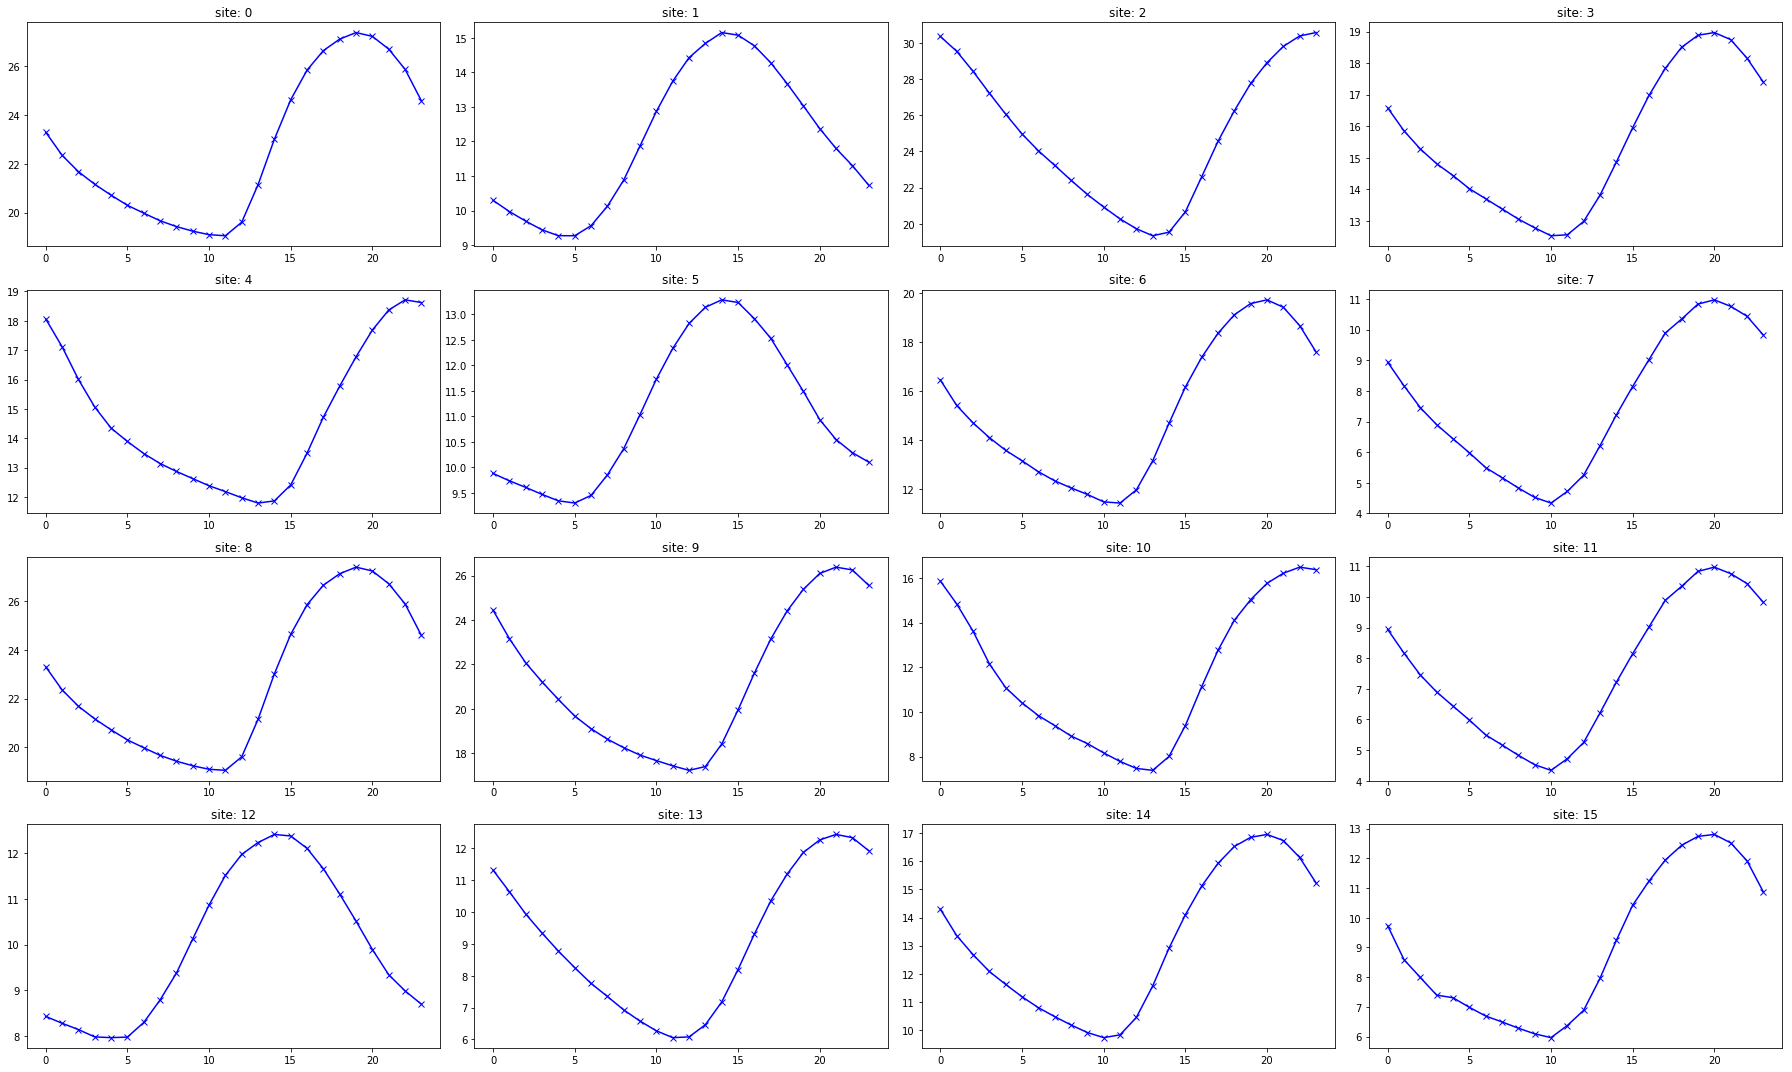

In [3]:
data_to_plot = temp_skeleton.copy()
data_to_plot["hour"] = data_to_plot["timestamp"].dt.hour
count = 1
plt.figure(figsize=(25, 15))
for site_id, data_by_site in data_to_plot.groupby('site_id'):
    by_site_by_hour = data_by_site.groupby('hour').mean()
    ax = plt.subplot(4, 4, count)
    plt.plot(by_site_by_hour.index,by_site_by_hour['air_temperature'],'xb-')
    ax.set_title('site: '+str(site_id))
    count += 1
plt.tight_layout()
plt.show()
del data_to_plot

As you can see in the previous graph, the **peak temperature appears at different time** in different sites. Quite some **even during the nights**, which doesn't make any sense. It means, the timestamp data here are not in their local time. As energy consumptions are related to the local time, an alighment is nescessary before using timestamp. We would calculate the differences between peak temperature times and 14:00, assume these results are the offsets, and align the timestamp of every site with them.

This following cell made LB jumped from 1.12 to 1.11. 

In [4]:
# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

In [5]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
!ls ../input

ashrae-energy-prediction  ashrae-feather-format-for-fast-loading


In [7]:
%%time
root = Path('../input/ashrae-feather-format-for-fast-loading')

train_df = pd.read_feather(root/'train.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead



CPU times: user 2.66 s, sys: 1.15 s, total: 3.81 s
Wall time: 9.26 s


/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



In [8]:
building_site_dict = dict(zip(building_meta_df['building_id'], building_meta_df['site_id']))
site_meter_raw = train_df[['building_id', 'meter', 'timestamp', 'meter_reading']].copy()
site_meter_raw['site_id'] = site_meter_raw.building_id.map(building_site_dict)
del site_meter_raw['building_id']
site_meter_to_plot = site_meter_raw.copy()
site_meter_to_plot["hour"] = site_meter_to_plot["timestamp"].dt.hour
elec_to_plot = site_meter_to_plot[site_meter_to_plot.meter == 0]

Do we also need to align the train data? Below is the electric consumptions & site graph, where timestamp are more aligned. Only site 14 is different, where the consumptions start from 10:00 am, while it's consumption ratio is also different with others. In Site 14 Education ranks first, which might be a reason of the expection. My guess is weather and train data come from different source, that's maybe also why they are in two seperete datasets.

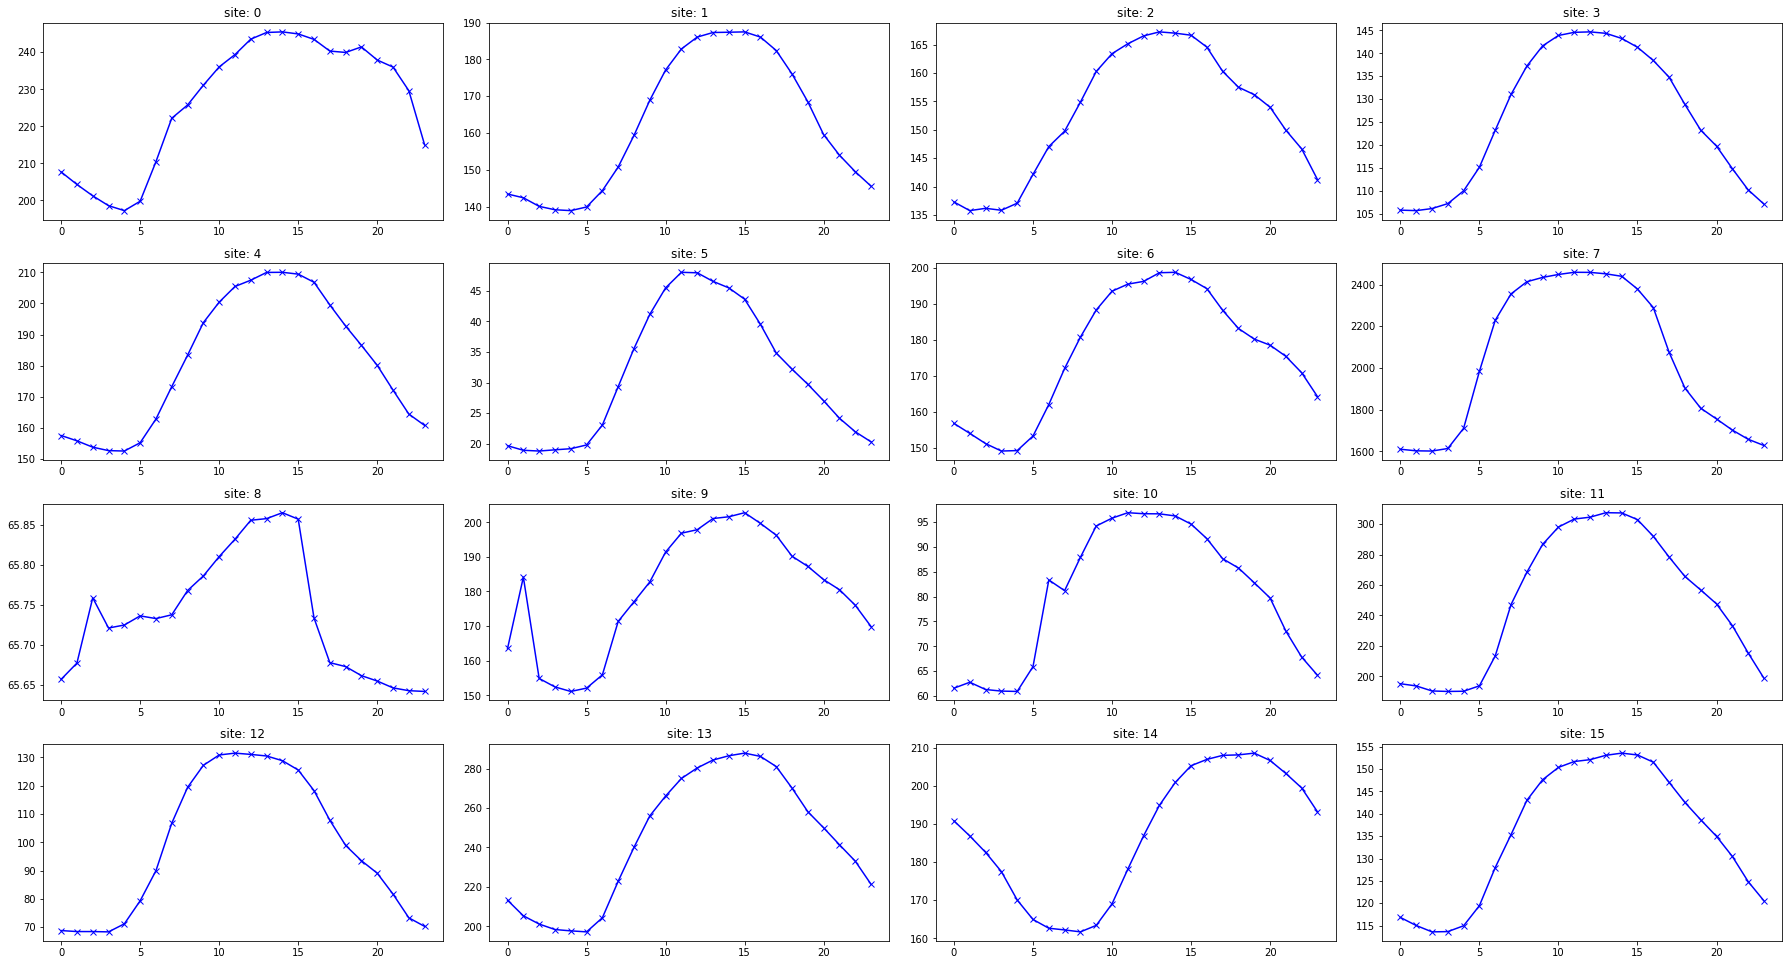

In [9]:
count = 1
plt.figure(figsize=(25, 50))
for site_id, data_by_site in elec_to_plot.groupby('site_id'):
    by_site_by_hour = data_by_site.groupby('hour').mean()
    ax = plt.subplot(15, 4, count)
    plt.plot(by_site_by_hour.index,by_site_by_hour['meter_reading'],'xb-')
    ax.set_title('site: '+str(site_id))
    count += 1
plt.tight_layout()
plt.show()
del elec_to_plot, site_meter_to_plot, building_site_dict, site_meter_raw

In [10]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]
        
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])
building_meta_df[building_meta_df.site_id == 0]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')
debug = False    
preprocess(train_df)

# https://www.kaggle.com/ryches/simple-lgbm-solution
df_group = train_df.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

train_df['building_mean'] = train_df['building_id'].map(building_mean)
train_df['building_median'] = train_df['building_id'].map(building_median)
train_df['building_min'] = train_df['building_id'].map(building_min)
train_df['building_max'] = train_df['building_id'].map(building_max)
train_df['building_std'] = train_df['building_id'].map(building_std)

weather_train_df = timestamp_align(weather_train_df)
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

reduce_mem_usage(train_df, use_float16=True)
reduce_mem_usage(building_meta_df, use_float16=True)
reduce_mem_usage(weather_train_df, use_float16=True)

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}
Memory usage of dataframe is 1459.10 MB
Memory usage after optimization is: 776.94 MB
Decreased by 46.8%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.02 MB
Decreased by 24.1%
Memory usage of dataframe is 20.93 MB
Memory usage after optimization is: 18.13 MB
Decreased by 13.4%


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 19:00:00,25.000000,6.0,20.000000,-1.0,1019.5,0.0,0.000000,5,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 20:00:00,24.406250,4.0,21.093750,-1.0,1020.0,70.0,1.500000,5,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 21:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000,5,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 22:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000,5,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2015-12-31 23:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609,5,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 13:00:00,3.000000,1.5,-8.000000,-1.0,1007.5,180.0,5.699219,6,...,1000.0,6.726562,211.000000,310.0,0.0,72.00000,5.046875,11.296875,0.0,2.525391
139769,15,2016-12-31 14:00:00,2.800781,2.0,-8.898438,-1.0,1007.5,180.0,7.699219,6,...,1000.0,6.578125,209.875000,310.0,0.0,71.87500,5.125000,11.296875,0.0,2.519531
139770,15,2016-12-31 15:00:00,2.800781,2.0,-7.199219,-1.0,1007.5,180.0,5.101562,6,...,1000.0,6.421875,212.375000,310.0,0.0,67.43750,5.195312,11.296875,0.0,2.443359
139771,15,2016-12-31 16:00:00,2.199219,2.0,-6.699219,-1.0,1008.0,170.0,4.601562,6,...,1000.0,6.246094,211.375000,310.0,0.0,67.56250,5.226562,11.296875,0.0,2.423828


In [11]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend', # 'month' , 'dayofweek'
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed', 'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',
    'wind_direction_mean_lag3', 'wind_speed_mean_lag3']

In [12]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

target_meter 0 (11714696, 34)
cat_features [31, 32, 33]
train 9371756 valid 2342940
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.679837	valid_1's l2: 0.718822
[40]	training's l2: 0.412642	valid_1's l2: 0.492271
[60]	training's l2: 0.355534	valid_1's l2: 0.459905
[80]	training's l2: 0.326835	valid_1's l2: 0.452833
[100]	training's l2: 0.298766	valid_1's l2: 0.452898
Early stopping, best iteration is:
[90]	training's l2: 0.312357	valid_1's l2: 0.450623
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.3123574204610767)]), 'valid_1': OrderedDict([('l2', 0.4506230767159248)])})
train 9371757 valid 2342939
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.706789	valid_1's l2: 0.639737
[40]	training's l2: 0.440276	valid_1's l2: 0.376908
[60]	training's l2: 0.380055	valid_1's l2: 0.32895
[80]	training's l2: 0.350315	valid_1's l2: 0.315827
[100]	training's l2: 0.319312	valid_1's l2: 0.314566
[120]	training's l2: 0.299411	valid_1's l2: 0.315255
Early 

10

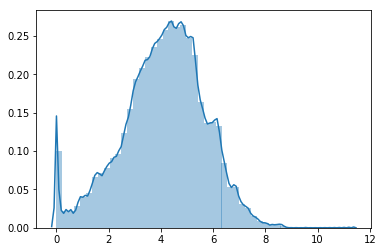

In [13]:
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 1 (4182440, 34)
cat_features [31, 32, 33]
train 3345952 valid 836488
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.3975	valid_1's l2: 2.80229
[40]	training's l2: 1.69882	valid_1's l2: 1.93323
[60]	training's l2: 1.45566	valid_1's l2: 1.74945
[80]	training's l2: 1.33599	valid_1's l2: 1.69667
[100]	training's l2: 1.25186	valid_1's l2: 1.67147
[120]	training's l2: 1.192	valid_1's l2: 1.65894
[140]	training's l2: 1.14768	valid_1's l2: 1.65681
Early stopping, best iteration is:
[127]	training's l2: 1.17665	valid_1's l2: 1.65525
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.1766538560445834)]), 'valid_1': OrderedDict([('l2', 1.655247169833506)])})
train 3345952 valid 836488
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.38878	valid_1's l2: 2.44129
[40]	training's l2: 1.65744	valid_1's l2: 1.87419
[60]	training's l2: 1.41856	valid_1's

10

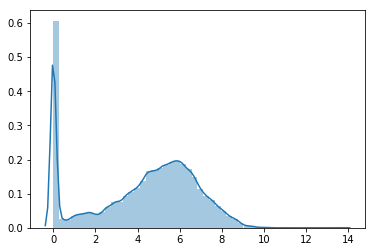

In [14]:
target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 2 (2708713, 34)
cat_features [31, 32, 33]
train 2166970 valid 541743
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.58194	valid_1's l2: 3.17672
[40]	training's l2: 1.88215	valid_1's l2: 2.57823
[60]	training's l2: 1.68394	valid_1's l2: 2.47244
[80]	training's l2: 1.58467	valid_1's l2: 2.44272
[100]	training's l2: 1.50245	valid_1's l2: 2.43411
[120]	training's l2: 1.4497	valid_1's l2: 2.43278
Early stopping, best iteration is:
[104]	training's l2: 1.4911	valid_1's l2: 2.43145
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.491102296447619)]), 'valid_1': OrderedDict([('l2', 2.4314520350040016)])})
train 2166970 valid 541743
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.56112	valid_1's l2: 2.89456
[40]	training's l2: 1.83056	valid_1's l2: 2.39694
[60]	training's l2: 1.62901	valid_1's l2: 2.30021
[80]	training's l2: 1.53262	valid_1's

10

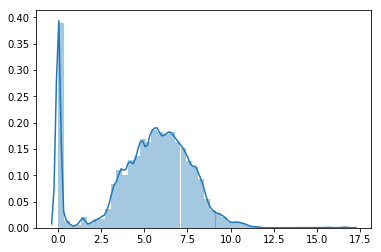

In [15]:
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 3 (1264037, 34)
cat_features [31, 32, 33]
train 1011229 valid 252808
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 3.50066	valid_1's l2: 4.24968
[40]	training's l2: 2.47914	valid_1's l2: 3.1352
[60]	training's l2: 2.1191	valid_1's l2: 2.70249
[80]	training's l2: 1.96327	valid_1's l2: 2.52269
[100]	training's l2: 1.86884	valid_1's l2: 2.44257
[120]	training's l2: 1.8003	valid_1's l2: 2.39066
[140]	training's l2: 1.74372	valid_1's l2: 2.3529
[160]	training's l2: 1.70174	valid_1's l2: 2.33247
[180]	training's l2: 1.66713	valid_1's l2: 2.31542
[200]	training's l2: 1.63776	valid_1's l2: 2.31095
[220]	training's l2: 1.61243	valid_1's l2: 2.30568
[240]	training's l2: 1.58097	valid_1's l2: 2.30648
Early stopping, best iteration is:
[225]	training's l2: 1.60435	valid_1's l2: 2.30493
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.6043504652891072)]), 'valid_1': OrderedDict([('l2', 2.304933

10

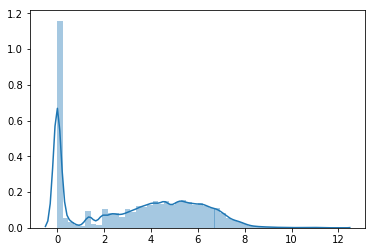

In [16]:
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

In [17]:
print('loading...')
test_df = pd.read_feather(root/'test.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')

print('preprocessing building...')
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)
test_df['building_mean'] = test_df['building_id'].map(building_mean)
test_df['building_median'] = test_df['building_id'].map(building_median)
test_df['building_min'] = test_df['building_id'].map(building_min)
test_df['building_max'] = test_df['building_id'].map(building_max)
test_df['building_std'] = test_df['building_id'].map(building_std)

print('preprocessing weather...')
weather_test_df = timestamp_align(weather_test_df)
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

print('reduce mem usage...')
reduce_mem_usage(test_df, use_float16=True)
reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

loading...


/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 2584.79 MB
Memory usage after optimization is: 1232.77 MB
Decreased by 52.3%
Memory usage of dataframe is 41.51 MB
Memory usage after optimization is: 35.96 MB
Decreased by 13.4%


0

In [18]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
reduce_mem_usage(sample_submission)

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [19]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [20]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

iterations 25
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 27min 7s, sys: 1min 43s, total: 28min 51s
Wall time: 9min 4s


10

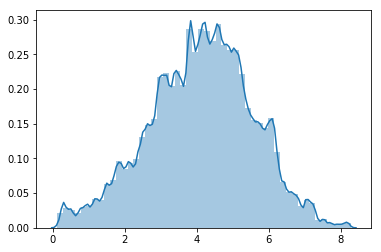

In [21]:
%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()

iterations 9
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 15min, sys: 35 s, total: 15min 35s
Wall time: 4min 37s


25

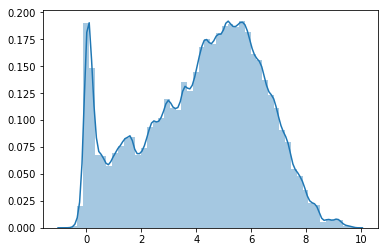

In [22]:
%%time
X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

del X_test
gc.collect()

iterations 6
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 7min 51s, sys: 24.3 s, total: 8min 16s
Wall time: 2min 32s


22

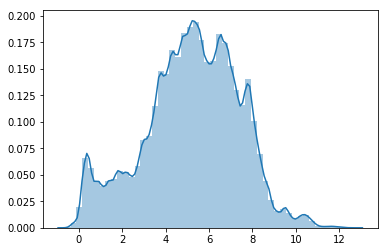

In [23]:
%%time
X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

del X_test
gc.collect()

iterations 3
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


19

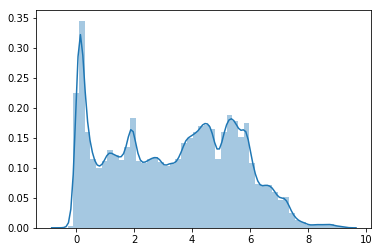

In [24]:
X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

del X_test
gc.collect()

In [25]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [26]:
sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')
sample_submission.head()

,row_id,meter_reading
0,0,173.293349
1,1,85.961084
2,2,9.242190
3,3,304.818313
4,4,1360.680116


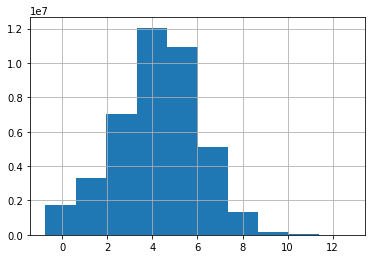

In [27]:
np.log1p(sample_submission['meter_reading']).hist()

In [28]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

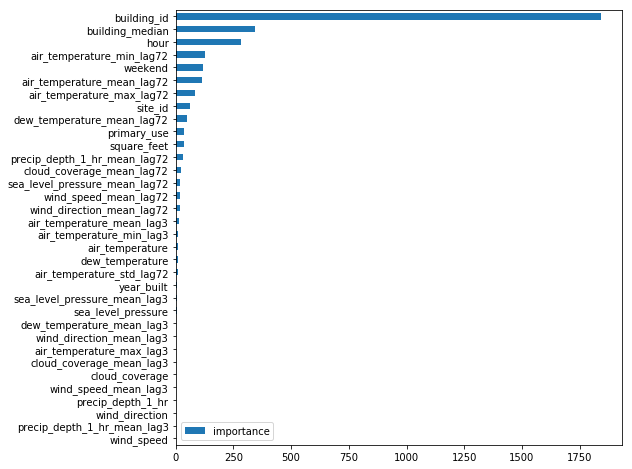

In [29]:
plot_feature_importance(models0[1])

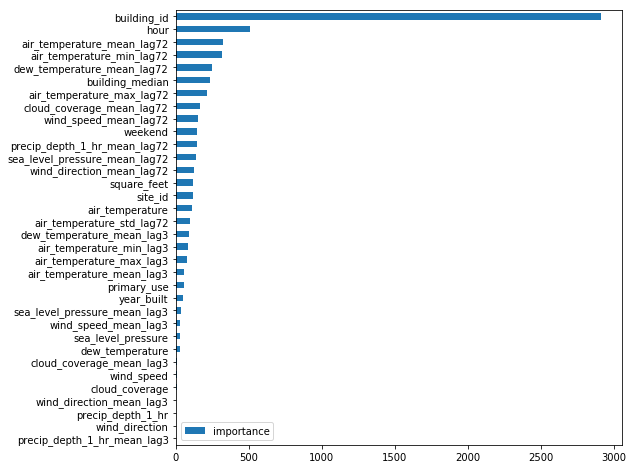

In [30]:
plot_feature_importance(models1[1])

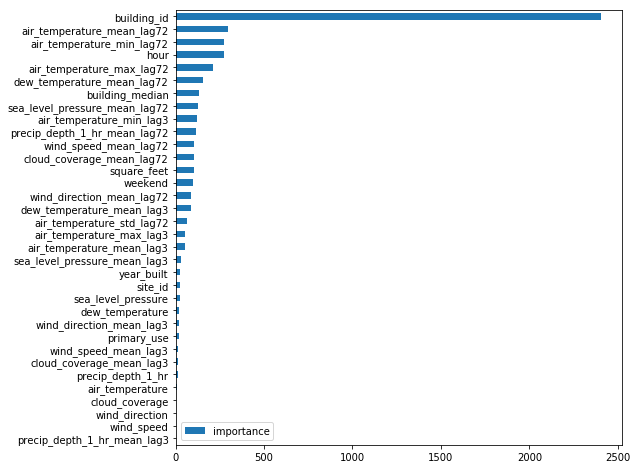

In [31]:
plot_feature_importance(models2[1])

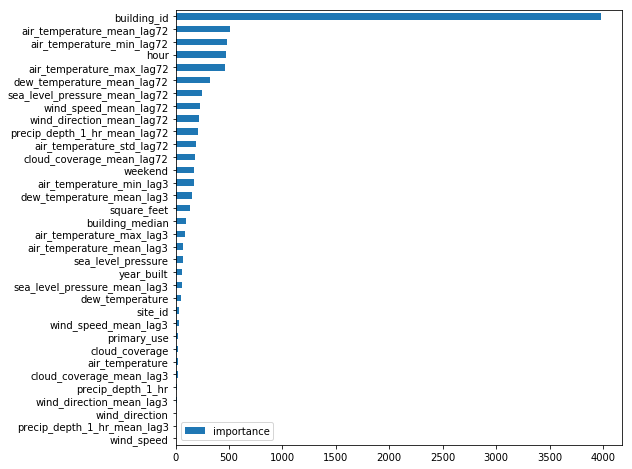

In [32]:
plot_feature_importance(models3[1])